In [37]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from cardinality_estimation.featurizer import Featurizer
from query_representation.query import load_qrep
from cardinality_estimation.dataset import *
from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup file paths / Download query data

In [38]:
import errno
def make_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [39]:
# TODO
# TRAINDIR = os.path.join(os.path.join("", "queries"), "mlsys1-train")
# VALDIR = os.path.join(os.path.join("", "queries"), "mlsys1-val")
# TESTDIR = os.path.join(os.path.join("", "queries"), "mlsys1-test")

TRAINDIR = os.path.join(os.path.join("", "queries"), "imdb")
#TRAINDIR = os.path.join(os.path.join("", "queries"), "job")

TESTDIR = os.path.join(os.path.join("", "queries"), "imdb")

RESULTDIR = os.path.join("", "results")
make_dir(RESULTDIR)

# Query loading helper functions

In [40]:

def load_qdata(fns):
    qreps = []
    for qfn in fns:
        qrep = load_qrep(qfn)
        # TODO: can do checks like no queries with zero cardinalities etc.
        qreps.append(qrep)
        template_name = os.path.basename(os.path.dirname(qfn))
        qrep["name"] = os.path.basename(qfn)
        qrep["template_name"] = template_name
    return qreps

def get_query_fns(basedir, template_fraction=1.0, sel_templates=None):
    fns = []
    tmpnames = list(glob.glob(os.path.join(basedir, "*")))
    assert template_fraction <= 1.0
    
    for qi,qdir in enumerate(tmpnames):
        if os.path.isfile(qdir):
            continue
        template_name = os.path.basename(qdir)
        
        if sel_templates is not None and template_name not in sel_templates:
            continue
        # let's first select all the qfns we are going to load
        qfns = list(glob.glob(os.path.join(qdir, "*.pkl")))
        qfns.sort()
        num_samples = max(int(len(qfns)*template_fraction), 1)
        random.seed(1234)
        qfns = random.sample(qfns, num_samples)
        fns += qfns
    return fns

# Load queries

In [41]:
# set template_fraction <= 1.0 to test quickly w/ smaller datasets
# train_qfns = get_query_fns(TRAINDIR, template_fraction = 0.001)
# val_qfns = get_query_fns(VALDIR, template_fraction = 1.0)
# test_qfns = get_query_fns(TESTDIR, template_fraction = 1.0)

#train_qfns = get_query_fns(TRAINDIR, template_fraction = 1.0, sel_templates=["3a", "3b"])

train_qfns = get_query_fns(TRAINDIR, template_fraction = 0.1, sel_templates=None)
val_qfns = []
#test_qfns = get_query_fns(TESTDIR, template_fraction = 1.0, sel_templates=["2a"])
test_qfns = []
print("Selected {} training queries, {} validation queries, {} test queries".\
      format(len(train_qfns), len(val_qfns), len(test_qfns)))

Selected 1357 training queries, 0 validation queries, 0 test queries


In [42]:
# going to start training the models
trainqs = load_qdata(train_qfns)

In [43]:
testqs = load_qdata(test_qfns)

In [44]:
allys = []
regexys = []
nonregexys = []

pg_allys = []
pg_regexys = []
pg_nonregexys = []

regex_single = []
nonregex_single = []

pg_regex_single = []
pg_nonregex_single = []

allselys = []
regexselys = []
nonregexselys = []

pg_allselys = []
pg_regexselys = []
pg_nonregexselys = []

TIMEOUT_CARD = 150001000000

for qrep in trainqs:
    jg = qrep["join_graph"]
    for node,data in qrep["subset_graph"].nodes(data=True):
        actual = data["cardinality"]["actual"]
        pg = data["cardinality"]["expected"]
        total = float(data["cardinality"]["total"])
        
        if actual >= TIMEOUT_CARD or pg >= TIMEOUT_CARD:
            continue
        
        allys.append(actual)
        allselys.append(actual/total)
        
        pg_allys.append(pg)
        pg_allselys.append(pg/total)
        
        is_regex = False
        
        for alias in node:
            for pt in jg.nodes()[alias]["pred_types"]:
                if "like" in pt:
                    is_regex = True
                    break
            if is_regex:
                regexys.append(actual)
                pg_regexys.append(pg)
                
                regexselys.append(actual/total)
                pg_regexselys.append(pg/total)
            else:
                nonregexys.append(actual)
                pg_nonregexys.append(pg)
                
                nonregexselys.append(actual/total)
                pg_nonregexselys.append(pg/total)
                
                        
        if len(node) == 1:
            if is_regex:
                regex_single.append(actual)
                pg_regex_single.append(pg)
            else:
                nonregex_single.append(actual)
                pg_nonregex_single.append(pg)

In [45]:
print(np.corrcoef(nonregex_single, pg_nonregex_single)[0,1])
print(np.corrcoef(nonregexys, pg_nonregexys)[0,1])

print(np.corrcoef(regex_single, pg_regex_single)[0,1])
print(np.corrcoef(regexys, pg_regexys)[0,1])

0.9075786371783614
0.6718450602132071
0.9962678010238385
0.8149910594791376


In [46]:
print(np.max(regexys), np.max(nonregexys))
# JOB MAX: 5607347034.0 5607347034.0

23795596119 23795596119


In [48]:
TIMEOUT_CARD - 23795596119

126205403881

In [49]:
TIMEOUT_CARD - 5607347034.0

144393652966.0

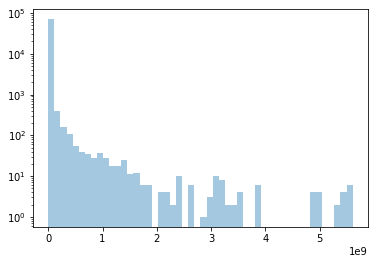

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(allys, kde=False)
plt.yscale("log")
#plt.xscale("log")

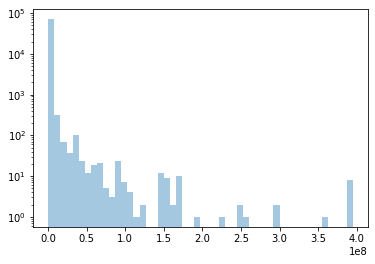

In [21]:
sns.distplot(pg_allys, kde=False)
plt.yscale("log")

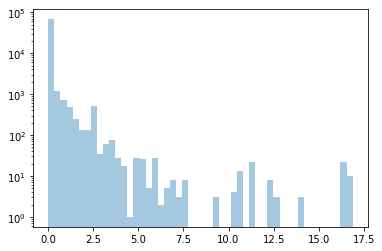

In [22]:
sns.distplot(allselys, kde=False)
plt.yscale("log")

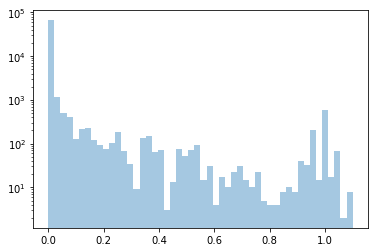

In [23]:
sns.distplot(pg_allselys, kde=False)
plt.yscale("log")

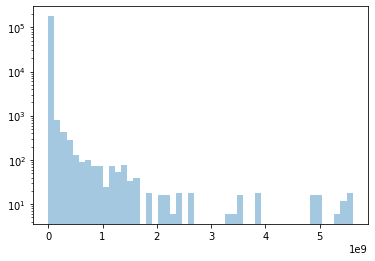

In [24]:
sns.distplot(regexys, kde=False)
plt.yscale("log")

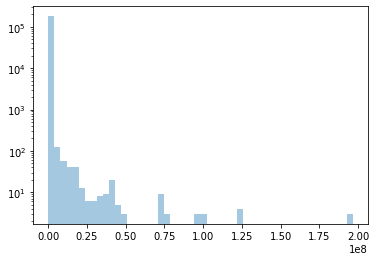

In [25]:
sns.distplot(pg_regexys, kde=False)
plt.yscale("log")

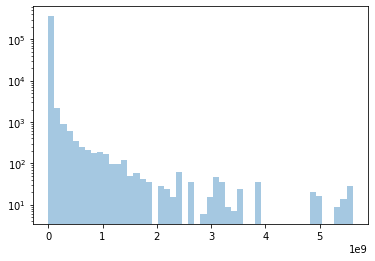

In [26]:
sns.distplot(nonregexys, kde=False)
plt.yscale("log")

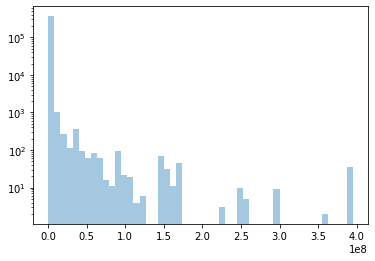

In [27]:
sns.distplot(pg_nonregexys, kde=False)
plt.yscale("log")

<AxesSubplot:>

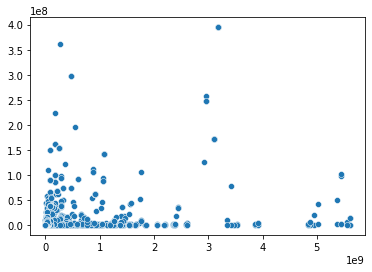

In [28]:
sns.scatterplot(x=allys, y=pg_allys)

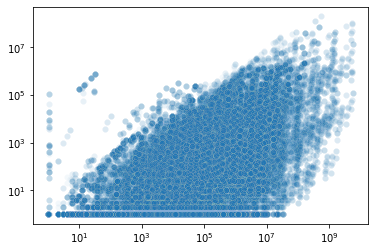

In [29]:
sns.scatterplot(x=regexys, y=pg_regexys, alpha=0.05)
# plt.xlim([0, 0.2*1e9])
# plt.ylim([0, 0.2*1e9])

# plt.xlim([0, 0.2*1e8])
# plt.ylim([0, 0.2*1e8])

plt.yscale("log")
plt.xscale("log")

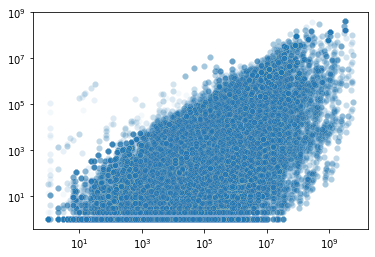

In [30]:
sns.scatterplot(x=nonregexys, y=pg_nonregexys, alpha=0.05)
plt.yscale("log")
plt.xscale("log")
# plt.xlim([0, 0.2*1e9])
# plt.ylim([0, 0.2*1e9])
# plt.xlim([0, 0.2*1e8])
# plt.ylim([0, 0.2*1e8])

(0.0, 1000000.0)

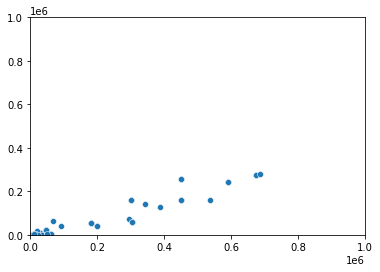

In [31]:
sns.scatterplot(x=regex_single, y=pg_regex_single)
plt.xlim([0, 1e6])
plt.ylim([0, 1e6])

(0.0, 1000000.0)

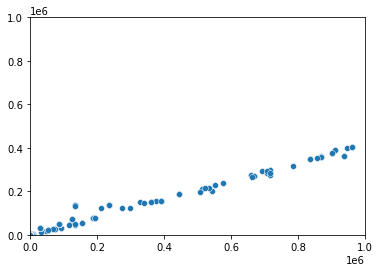

In [32]:
sns.scatterplot(x=nonregex_single, y=pg_nonregex_single)
plt.xlim([0, 1e6])
plt.ylim([0, 1e6])

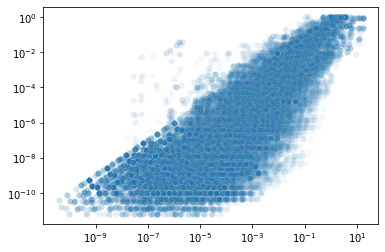

In [33]:
sns.scatterplot(x=allselys, y=pg_allselys, alpha=0.05)
plt.yscale("log")
plt.xscale("log")
# plt.xlim([0, 0.005])
# plt.ylim([0, 0.005])

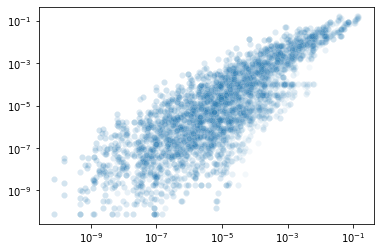

In [344]:
sns.scatterplot(x=regexselys, y=pg_regexselys, alpha=0.05)
plt.yscale("log")
plt.xscale("log")
# plt.xlim([0, 0.005])
# plt.ylim([0, 0.005])

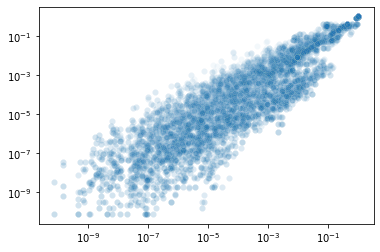

In [345]:
sns.scatterplot(x=nonregexselys, y=pg_nonregexselys, alpha=0.05)
#plt.xlim([0, 0.0001])
#plt.ylim([0, 0.0001])
plt.yscale("log")
plt.xscale("log")
# plt.xlim([0, 0.0001])
# plt.ylim([0, 0.0001])

In [326]:
np.log(allselys)

array([-0.225, -0.001, -3.597, ..., -12.658, -14.557, -14.600])